In [1]:
import os
import numpy as np
from tqdm.notebook import tqdm, trange

In [2]:
import torch
from goleta import data as D
from goleta import util as U

In [3]:
import corner as DFM
# --- plotting ---
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
if torch.cuda.is_available(): device = 'cuda'
else: device = 'cpu'

In [5]:
qphis = U.read_best_ndes('_qphi.omega_x', device=device)

33 models trained
[30, 16, 2, 31, 33]


In [20]:
X_all = D.get_obs(cut='')

123396 observed galaxies


/home/chhahn/projects/goleta/src/goleta/data.py:166: RuntimeWarning: divide by zero encountered in power
  Xs = np.concatenate([absmag_nsa[cuts], ivar_absmag_nsa[cuts]**-0.5], axis=1)


In [21]:
X_obs = D.get_obs(cut='v0')

14736 observed galaxies


/home/chhahn/projects/goleta/src/goleta/data.py:151: RuntimeWarning: divide by zero encountered in power
  (ivar_absmag_nsa[:,-1]**-0.5 > 0.03) & (ivar_absmag_nsa[:,-1]**-0.5 < 0.04)))


In [8]:
igals = np.random.choice(np.arange(X_obs.shape[0]), replace=False, size=5)

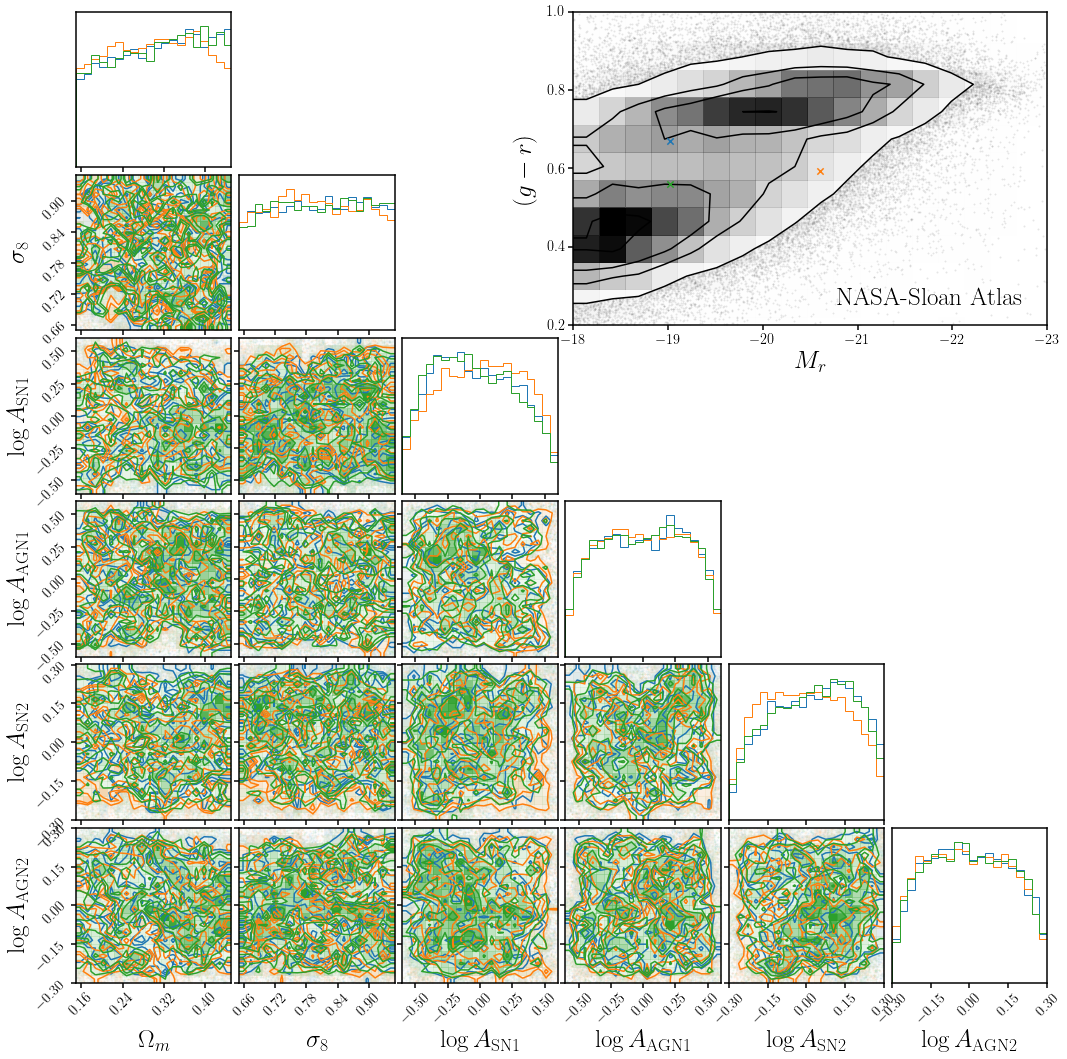

In [35]:
lbls = [r'$\Omega_m$', r'$\sigma_8$', 
        r'$\log A_{\rm SN1}$', r'$\log A_{\rm AGN1}$', 
        r'$\log A_{\rm SN2}$', r'$\log A_{\rm AGN2}$']
_range = [(0.15, 0.45), (0.65, 0.95), 
         (np.log10(0.25), np.log10(4.0)), (np.log10(0.25), np.log10(4.0)), 
         (np.log10(0.5), np.log10(2.0)), (np.log10(0.5), np.log10(2.0))]

fig = plt.figure(figsize=(15,15))

for _i, ii in enumerate(igals[:3]): 
    theta_prime = []
    for qphi in qphis: 
        _samp = qphi.sample((int(10000/len(qphis)),), 
                            x=torch.tensor(X_obs[ii]).to(device), 
                            show_progress_bars=False)
        theta_prime.append(_samp.detach().cpu().numpy())
    theta_prime = np.concatenate(theta_prime)

    _ = DFM.corner(theta_prime, range=_range,
                   hist_kwargs={'density': True}, color='C%i' % _i, 
                   labels=lbls, label_kwargs={'fontsize': 25}, fig=fig)
    
axes = np.array(fig.axes).reshape((6,6))
for i in range(6): 
    for j in range(6):
        axes[i,j].set_xlim(_range[j])
        if j < i: axes[i,j].set_ylim(_range[i])
            
sub = fig.add_subplot(3,2,2)
DFM.hist2d(X_all[:,1], X_all[:,0] - X_all[:,1], range=[(-18., -23.5), (-0.2, 1.2)], ax=sub)
for _i, ii in enumerate(igals[:3]): 
    sub.scatter([X_obs[ii,1]], [X_obs[ii,0] - X_obs[ii,1]], c='C%i' % _i, marker='x', s=40, zorder=10)
sub.text(0.95, 0.05, 'NASA-Sloan Atlas', transform=sub.transAxes, fontsize=25, ha='right', va='bottom')
sub.set_xlabel('$M_r$', fontsize=25)
sub.set_xlim(-18, -23.)
sub.set_ylabel('$(g-r)$', labelpad=10, fontsize=25)
sub.set_ylim(0.2, 1.)    
sub.set_yticks([0.2, 0.4, 0.6, 0.8, 1.])
fig.savefig('../figs/p_omega_x_i.pdf', bbox_inches='tight')